In [ ]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models
from torchvision.models.utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Dict, Optional, cast
from torch import Tensor
from collections import OrderedDict
from PIL import Image
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
import glob


In [ ]:
def linspacepixels(x1,x2,n):  
    """
    Args:
      x1 (scalar): lower end of range
      x2 (scalar): higher end of range
      n (scalar): number of desired points

    Returns:
      f (1D array): vector of equally spaced points that can be treated as centers
      of pixels whose total field-of-view would be bounded by <x1> and <x2>.
    
    """
    dif = ((x2-x1)/n)/2
    f = np.linspace(x1 + dif,x2-dif,n)
    return f
     
def calcunitcoordinates(res):
    
  """

  Args:
    res (scalar): the number of pixels along one side

  Returns:
    xx (2D array): x-coordinates corresponding to equally space points within the space bounded 
                   by -0.5 and 0.5. These points can be treated as centers of pixels.
    yy (2D array): y-coordinates corresponding to equally space points within the space bounded 
                   by -0.5 and 0.5. These points can be treated as centers of pixels.
                   
    Notice that the second argument proceeds from 0.5 to -0.5.
    this ensures that the results match the usual coordinate axes 
    where the top is the positive y-axis.
    
  """
  xx,yy = np.meshgrid(linspacepixels(-.5,.5,res),linspacepixels(.5,-.5,res));
  return xx, yy
 



def makegaussian2d(res,r,c,sr,sc):
    
    """
    Creates 2-dimensional gaussian

    Args:
      res (scalar): the number of pixels along one side
      r (scalar): the row associated with the peak of the Gaussian (can be a decimal).
      c (scalar): the column associated with the peak of the Gaussian (can be a decimal)
      sr (scalar): the standard deviation in the vertical direction
      sc (scalar): the standard deviation in the horizontal direction

    Returns:
      f (2D array): 2-dimensional gaussian. Values are in [0, 1].
    
    Note: if you want an L1-normalized image, divide the image by 2*pi*<sr>*<sc>.
    note that this is in reference to the ideal case where the Gaussian has 
    enough room to extend out.  so, if you are constructing a Gaussian that
    does not fit very well within the image, the actual L1 length of the image
    that is constructed will not be exactly 1.
    """ 
    
    xx,yy = calcunitcoordinates(res)
    # convert to the unit coordinate frame
    r = (-1/res) * r + (.5 + .5/res); 
    c = (1/res) * c + (-.5 - .5/res);  
    sr = sr/res;
    sc = sc/res;
  
    coord = np.vstack((xx.flatten('F')-c, yy.flatten('F')-r))

    # handle equal std dev as a separate case for speed reasons
    if sc==sr:
        f = (coord[0]**2+coord[1]**2)/-(2*sc**2);
    else:
        f = coord[0]**2/-(2*sr**2) + coord[1]**2/-(2*sc**2);

    f = np.exp(f);
    f = np.reshape(f,xx.shape)
    return f

    

In [ ]:
# ==============
# load alex net
# ==============
# alexnet = models.alexnet(pretrained=True)
# dir(models)
# print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Load Images

In [ ]:
# fname = "kay_labels.npy"
# if not os.path.exists(fname):
#   !wget -qO $fname https://osf.io/r638s/download
# fname = "kay_labels_val.npy"
# if not os.path.exists(fname):
#   !wget -qO $fname https://osf.io/yqb3e/download
# fname = "kay_images.npz"
# if not os.path.exists(fname):
#   !wget -qO $fname https://osf.io/ymnjv/download

In [ ]:
fname = 'kay_images.npz'
with np.load(fname) as dobj:
    dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

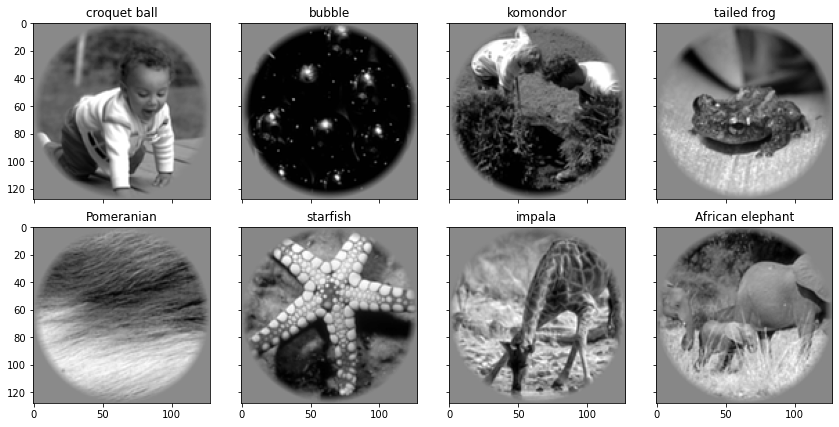

In [ ]:
f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[-1,:]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
f.tight_layout()

## Image Preprocessing

# New Section

In [ ]:
print(dict(zip(dat["roi_names"], np.bincount(dat["roi"]))))

1294 + 2083 + 1790 + 484 + 314 + 1535 + 928

{'Other': 0, 'V1': 1294, 'V2': 2083, 'V3': 1790, 'V3A': 484, 'V3B': 314, 'V4': 1535, 'LatOcc': 928}


8428

In [ ]:
#  from torchvision import transforms
#  transform = transforms.Compose([           #[1]
#  transforms.Grayscale(3),
#  transforms.Resize(256),                    #[2]
#  transforms.CenterCrop(224),                #[3]
#  transforms.ToTensor(),                     #[4]
#  transforms.Normalize(                      #[5]
#  mean=[0.485, 0.456, 0.406],                #[6]
#  std=[0.229, 0.224, 0.225]                  #[7]
#  )])


In [ ]:
# unloader = transforms.ToPILImage()
# def tensor_to_PIL(tensor):
#     image = tensor.cpu().clone()
#     image = image.squeeze(0)
#     image = unloader(image)
#     return image

In [ ]:
# num_samples = dat['stimuli'].shape[0]
# stimuli_images = torch.zeros((num_samples, 3,224, 224))

# for im in range(num_samples):
#   test_image = dat['stimuli'][im]
#   dat_tensor = torch.from_numpy(test_image)
#   stimuli_pil = tensor_to_PIL(dat_tensor)
#   stimuli_transform = transform(stimuli_pil)
#   stimuli_images[im,:,:,:] = stimuli_transform

# print(stimuli_images.shape)



In [ ]:
# alexnet.eval()
# # prediction = alexnet(torch.unsqueeze(stimuli_transform,0))
# prediction = alexnet(stimuli_images)
# print(prediction.shape)
# plt.plot(prediction.detach().cpu().numpy().T)
# plt.show()

In [ ]:
# =========================
# Extract layer activation
# =========================

# no_of_layers=0
# conv_layers=[]
# ReLU = []
# maxpool2d = []
 
# model_children=list(alexnet.children())

# for child in model_children:
#   if type(child)==nn.Conv2d:
#     no_of_layers+=1
#     conv_layers.append(child)
#   elif type(child)==nn.Sequential:
#     for layer in child.children():
#       if (type(layer)==nn.Conv2d):
#         no_of_layers+=1
#         conv_layers.append(layer)
#       elif type(layer) == nn.ReLU:
#         no_of_layers+=1
#         ReLU.append(layer)
#       elif type(layer) == nn.MaxPool2d:
#         no_of_layers+=1
#         maxpool2d.append(layer)

# print(no_of_layers)

# # # results = [conv_layers[0](torch.unsqueeze(stimuli_transform,0))]
# outputs = []
# tmpresults = [conv_layers[0](stimuli_images)]
# tmpresults.append(ReLU[0](tmpresults[-1]))
# tmpresults.append(maxpool2d[0](tmpresults[-1]))
# outputs.append(tmpresults[-1])


# for i in range(1, len(conv_layers)):
#     # results[i] = conv_layers[i](results[i-1]) 
#     tmpresults.append(conv_layers[i](tmpresults[-1]))  
#     tmpresults.append(ReLU[i](tmpresults[-1]))
#     if (i == 1):
#       tmpresults.append(maxpool2d[i](tmpresults[-1]))
#     elif (i == 4):
#       tmpresults.append(maxpool2d[i-2](tmpresults[-1]))
#     outputs.append(tmpresults[-1]) 
    
# print(outputs[0].shape,outputs[1].shape,outputs[2].shape,outputs[3].shape,outputs[4].shape)
# np.save('layer_activation.npy',outputs)
outputs = np.load('layer_activation.npy',allow_pickle=True)

In [ ]:
type(outputs)

numpy.ndarray

In [ ]:
#model_children

NameError: ignored

In [ ]:
print(outputs[0].shape,outputs[1].shape,outputs[2].shape,outputs[3].shape,outputs[4].shape)
type(outputs)

Layer  1


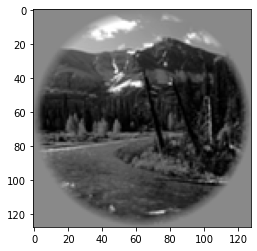

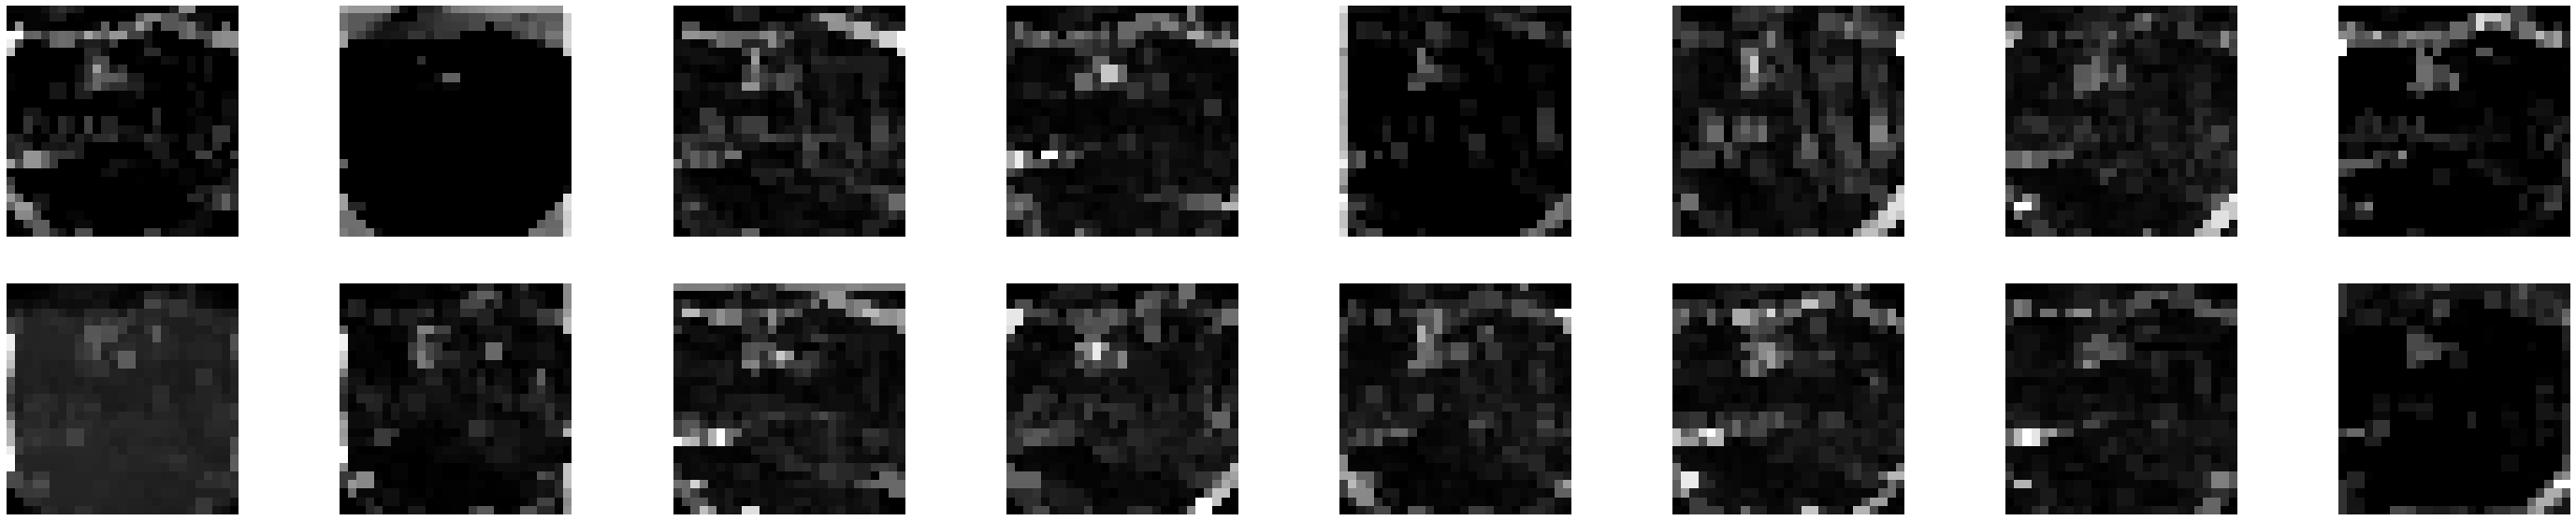

Layer  2


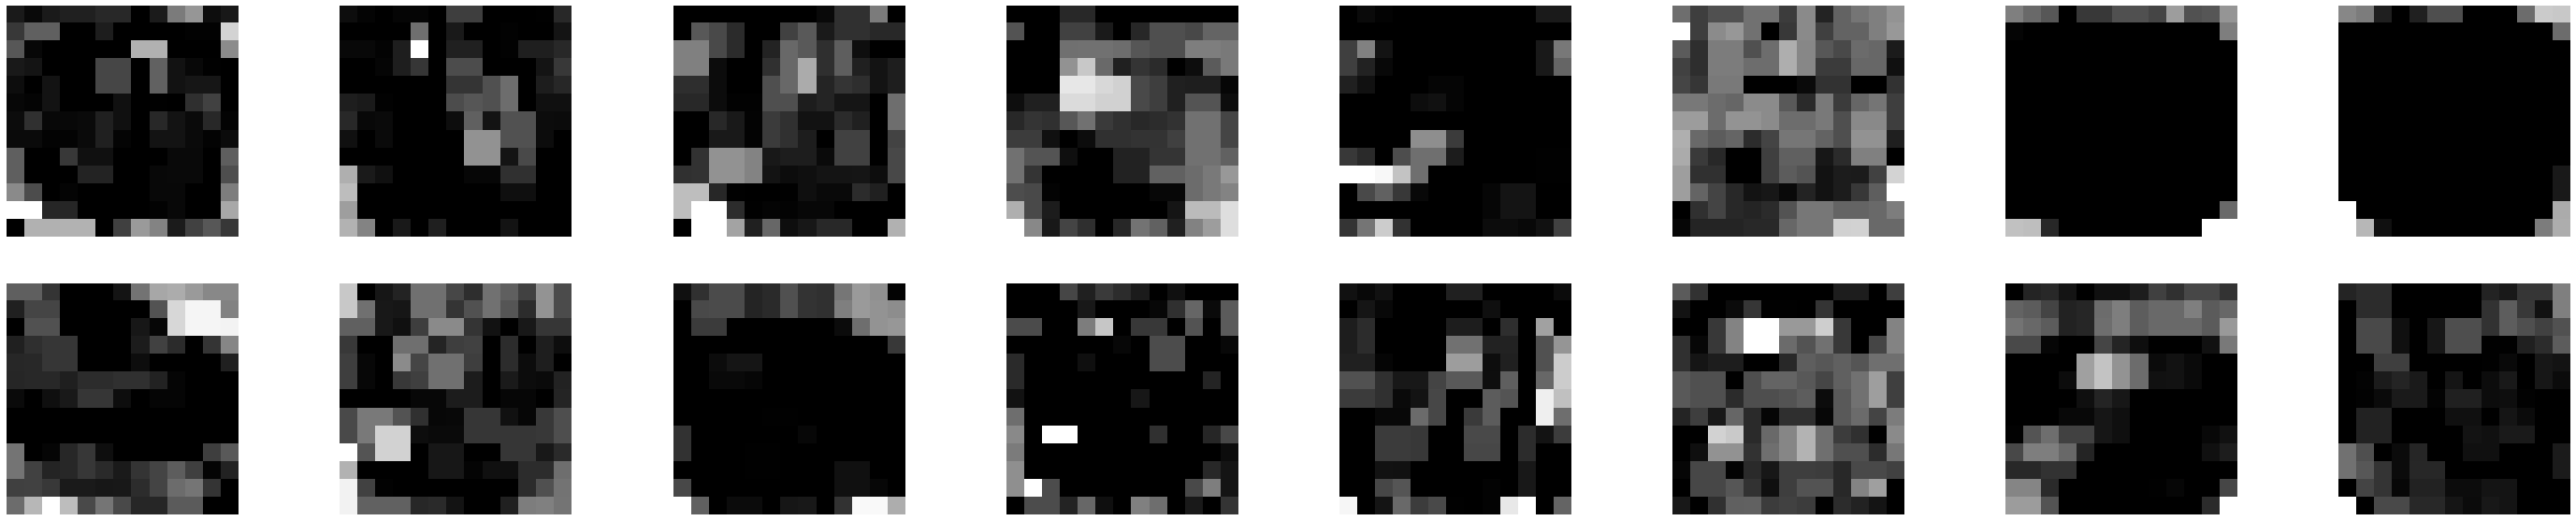

Layer  3


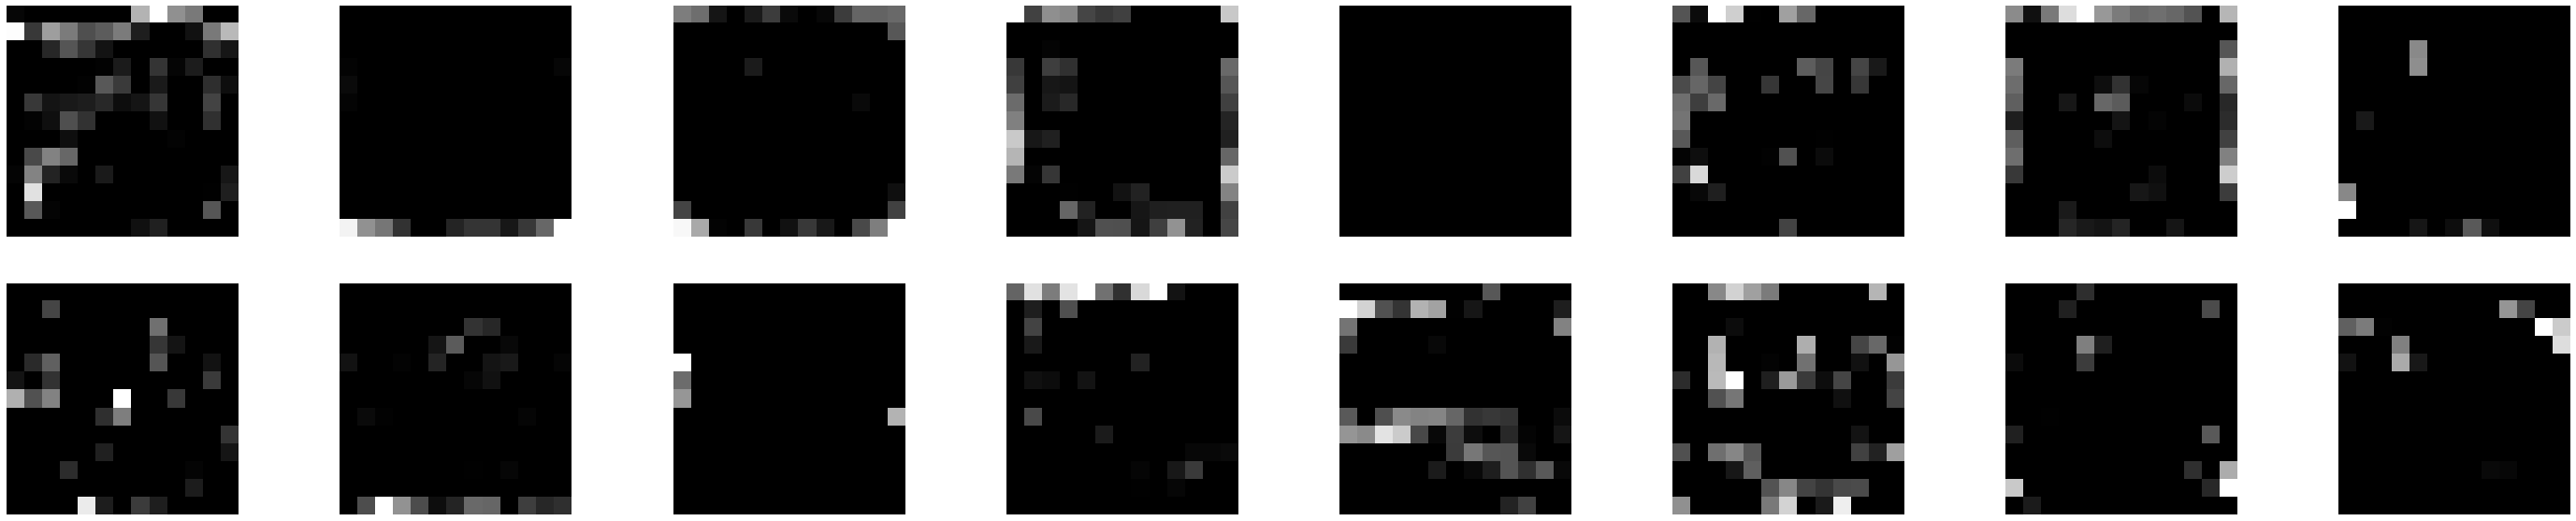

Layer  4


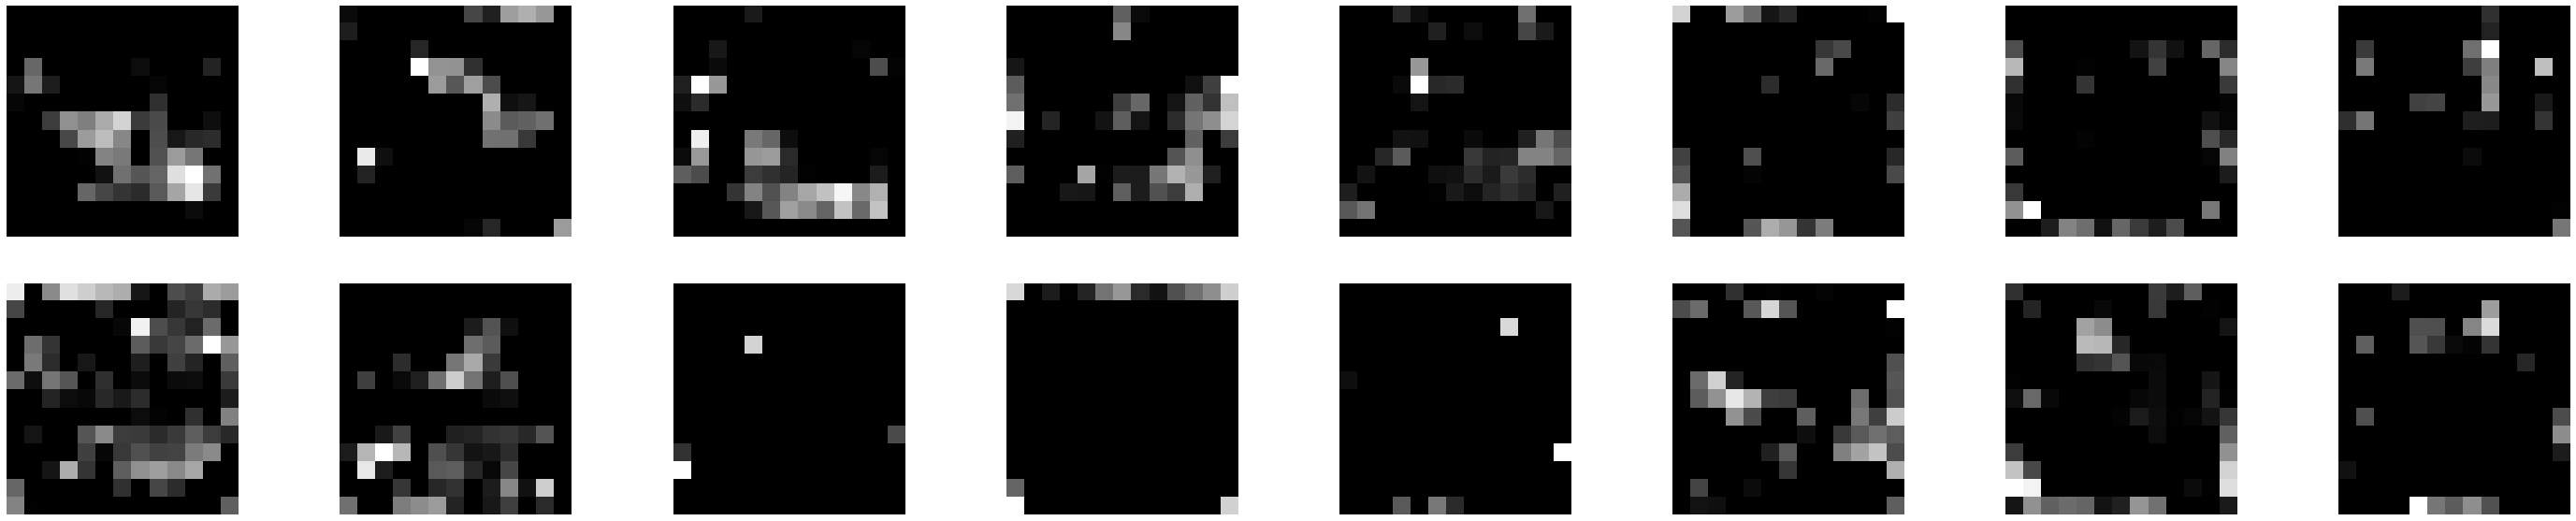

Layer  5


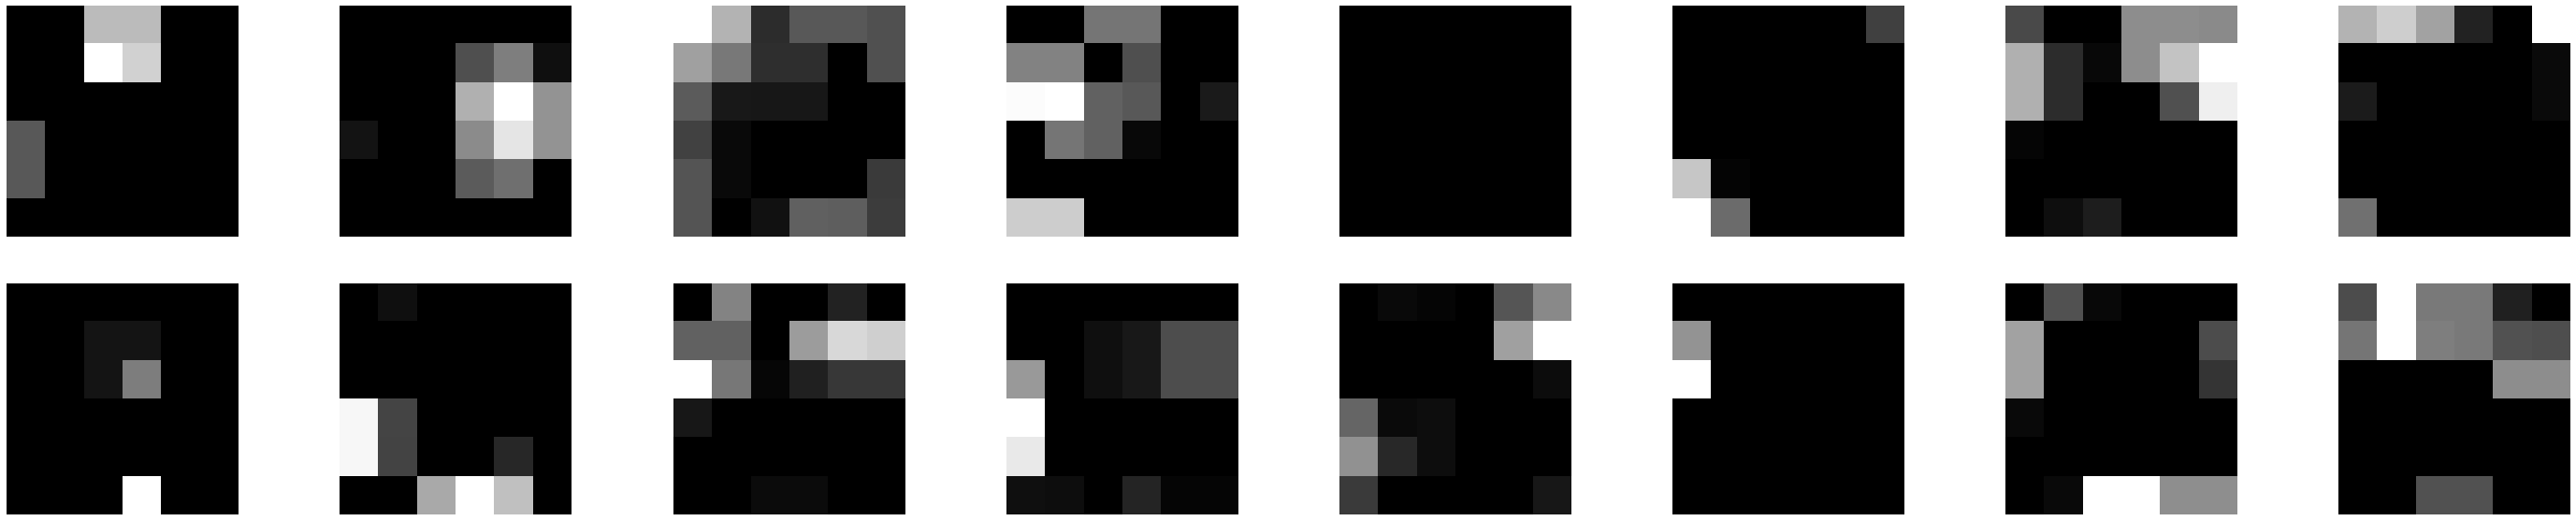

In [ ]:
imidx = 65
test_image = dat['stimuli'][imidx]
plt.imshow(test_image, cmap = 'gray')

for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][imidx, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()


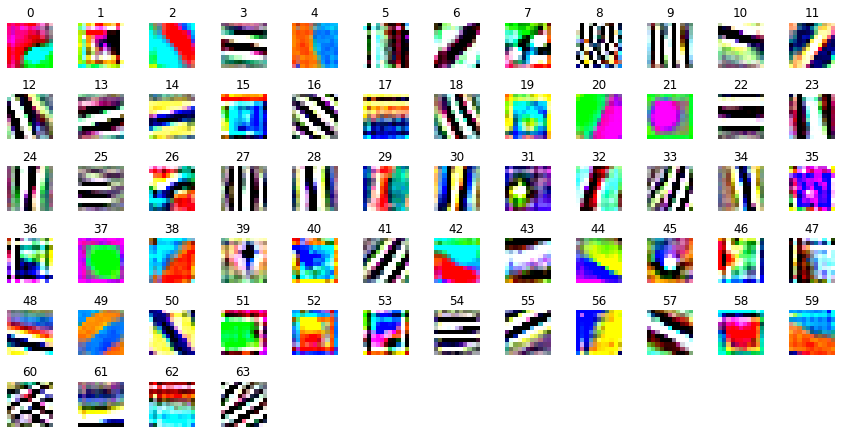

In [ ]:
def imshow(img, title):
  
  """Custom function to display the image using matplotlib"""
  
  #define std correction to be made
  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  
  #define mean correction to be made
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  
  #convert the tensor img to numpy img and de normalize 
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction
  
  #plot the numpy image
  plt.figure(figsize = (batch_size * 4, 4))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

#custom function to fetch images from dataloader

def show_batch_images(dataloader):
  images,_ = next(iter(dataloader))
  
  #run the model on the images
  outputs = model(images)
  
  #get the maximum class 
  _, pred = torch.max(outputs.data, 1)
  
  #make grid
  img = torchvision.utils.make_grid(images)
  
  #call the function
  imshow(img, title=[classes[x.item()] for x in pred])
  
  return images, pred

def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

#plotting single channel images
plot_weights(alexnet, 0, single_channel = False)

## fMRI Responses

## Building the Encoding Models: 
 $$ min \|y - Wx\| + \lambda \|W\|^2$$




In [ ]:
def create_2d_gaussian_grid(layeridx,layers):

  # define 2D gaussian grid
  res = (layers[layeridx].shape[2],layers[layeridx].shape[3])  # resolution of the pre-processed stimuli
  eccs = np.array([0, 0.00551, 0.014, 0.0269, 0.0459, 0.0731, 0.112, 0.166, 0.242, 0.348, 0.498, 0.707, 1]);
  angs = np.linspace(0,2*np.pi,16)
  angs = angs[0:15]
  angs * (180/np.pi)
  resmx = np.max(res);
  maxn = np.floor(np.log2(resmx)) # calculate sigma gridding (pRF size is 1 px, 2 px, 4 px, ..., up to resmx)

  ssindices = np.exp2(np.arange(0,maxn+1))
  ssindices

  # construct full list of seeds (seeds x params) [R C S]
  allseeds = np.zeros((len(eccs)*len(angs)*len(ssindices),3))
  allseeds.shape
  cnt = 0
  for p in range(len(eccs)):
    for q in range(len(angs)):
      if p==1 and q>1:  # for the center-of-gaze, only do the first angle
        continue
      for s in range(len(ssindices)):
        allseeds[cnt,:] = np.array([(1+res[0])/2 - np.sin(angs[q]) * (eccs[p]*resmx),
                            (1+res[1])/2 + np.cos(angs[q]) * (eccs[p]*resmx),
                            ssindices[s]])
        cnt += 1


  allseeds = allseeds[0:cnt,:]
  return allseeds, res

In [ ]:
# y_response = np.squeeze(dat['responses'][:,np.where(dat['roi'] == 4)])
# allseeds, res = create_2d_gaussian_grid(0,outputs)
# X_features = outputs[0].detach().numpy()
# num_samples = X_features.shape[0]
# nchan = X_features.shape[1]
# X_features_FWRF = np.zeros((num_samples,nchan))
# gauss = np.tile(makegaussian2d(np.max(res),allseeds[50,0],allseeds[50,1],allseeds[50,2],allseeds[50,2]),(num_samples,1,1))
# # convolve each channel w/ 2D gaussian
# for k in range(0,nchan):
#   X_features_FWRF[:,k] = np.sum(gauss*X_features[:,k,:,:],axis = (1,2))
# ridge_reg_model = linear_model.RidgeCV(alphas=[0.5],alpha_per_target=True)

# fit = ridge_reg_model.fit(X_features_FWRF, y_response)
# fit.coef_.shape

# wts = np.zeros((nvx,nchan))
# pred = cross_val_predict(ridge_reg_model, X_features_FWRF, y_response, cv=5)
# r2scores = r2_score(y_response, pred, multioutput = 'raw_values') 
  

(484, 64)

In [ ]:
alphas = np.array([0.5, 1, 5, 10])# np.logspace(-1,3,5) #np.logspace(-2, 4,7) # Ridge penalty
alphas = np.array([0.5])
def fwRF_cv(r,l,activations,alphas,dat):
    y_response = np.squeeze(dat['responses'][:,np.where(dat['roi'] == r)]) 
    nvx = y_response.shape[1]
    allseeds,res = create_2d_gaussian_grid(l,activations)
    X_features = activations[l].detach().numpy()
    num_samples = X_features.shape[0]
    nchan = X_features.shape[1]  
    X_features_FWRF = np.zeros((num_samples,nchan))
    pred = np.zeros((y_response.shape[0],nvx, len(alphas),allseeds.shape[0]))
    r2scores = np.zeros((len(alphas),allseeds.shape[0],nvx))

    # if ROI is large, fit model in batches
    if nvx > 300:
      nbatch = int(np.ceil(nvx/300))
      batchidx = [None] * nbatch
      for b in range(nbatch):
        if (b+1) < nbatch:
          batchidx[b] = np.mgrid[(0 + (b*300)):(0 + (b*300))+300:1]
        else:
          batchidx[b] = np.mgrid[(0 + (b*300)):nvx:1] 

    for i in range(allseeds.shape[0]): # loop over 2D gaussians
      # print progress
      if np.mod(i,25) == 0:
        print('%d / %d' % (i,allseeds.shape[0]))
      
      # generate 2D gaussian
      gauss = np.tile(makegaussian2d(np.max(res),allseeds[i,0],allseeds[i,1],allseeds[i,2],allseeds[i,2]),(num_samples,1,1))
      
      # convolve each channel w/ 2D gaussian
      for k in range(0,nchan):
        X_features_FWRF[:,k] = np.sum(gauss*X_features[:,k,:,:],axis = (1,2))
      
      # cross-validation
      if nvx > 300:
        for b in range(nbatch):
          print(b)
          for j,a in enumerate(alphas):
            #print(a)
            ridge_reg_model = linear_model.Ridge(alpha=a)
            pred[:,batchidx[b],j,i] = cross_val_predict(ridge_reg_model, X_features_FWRF, y_response[:,batchidx[b]], cv=5) #,n_jobs=6)
            r2scores[j,i,batchidx[b]] = r2_score(y_response[:,batchidx[b]], pred[:,batchidx[b],j,i], multioutput = 'raw_values')
      else:
        for j,a in enumerate(alphas):
          #print(a)
          ridge_reg_model = linear_model.Ridge(alpha=a)
          pred[:,:,j,i] = cross_val_predict(ridge_reg_model, X_features_FWRF, y_response, cv=5) #,n_jobs=6)
          r2scores[j,i,:] = r2_score(y_response, pred[:,:,j,i], multioutput = 'raw_values')


    np.save('r2scores_%s_layer%d.npy' % (dat['roi_names'][r],l) ,r2scores)
    np.save('predictions_%s_layer%d.npy' % (dat['roi_names'][r],l),pred)


In [ ]:
for l in [3, 4]:
  fwRF_cv(1,l,outputs,alphas,dat)

for r in [2,3]:
  for l in range(5):
    fwRF_cv(r,l,outputs,alphas,dat)

for l in range(1,5):
  fwRF_cv(7,l,outputs,alphas,dat)


Streaming output truncated to the last 5000 lines.
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
450 / 546
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
475 / 546
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
500 / 546
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
525 / 546
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0

In [ ]:

nvx = predictions.shape[1]
alphas = np.array([0.5])
bestidx = np.argmax(r2scores.reshape((len(alphas) * allseeds.shape[0],nvx)),axis = 0)
#import seaborn as sns
#sns.heatmap(r2scores[0,:,0:nvx],cmap = 'Blues')
plt.imshow(r2scores[0,:,0:nvx],cmap = 'hot')
plt.colorbar()
plt.show()
np.sum(r2scores>0)

NameError: ignored

In [ ]:

# alphas = np.array([0.5])
# y_response = np.squeeze(dat['responses'][:,np.where(dat['roi'] == 1)])
# for l in range(5):
#   pred = np.load('predictions_V1_layer%d.npy' % l)
#   r2scores = np.load('r2scores_V1_layer%d.npy' % l)
#   nvx = pred.shape[1]
#   allseeds,res = create_2d_gaussian_grid(l,outputs)
#   bestidx = np.argmax(r2scores.reshape((len(alphas) * allseeds.shape[0],nvx)),axis = 0)
#   vxidx = 24
#   plt.plot(y_response[0:100,vxidx],color = 'black',label = 'Voxel Response')
#   plt.plot(np.squeeze(pred[0:100,vxidx,0,bestidx[vxidx]]),color = np.random.rand(3),label = 'Layer %d' % l ) 
#   np.corrcoef(pred[:,vxidx,0,bestidx[vxidx]],y_response[:,vxidx])
# plt.legend()
# plt.show()

In [ ]:
# distribution of correlation

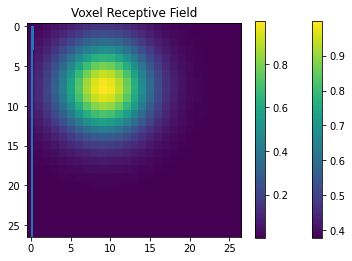

In [ ]:
alphas = np.array([0.5])
r2scores = np.load('r2scores_V1_layer0.npy')
allseeds,res = create_2d_gaussian_grid(0,outputs)
nvx = r2scores.shape[2]
bestidx = np.argmax(r2scores.reshape((len(alphas) * allseeds.shape[0],nvx)),axis = 0)
bestr2 = np.amax(np.squeeze(r2scores),axis = 0)

np.sum(bestr2>0.01)
plt.hist(bestr2)


# vxidx = 357
npx = np.prod(res)
pRFs = np.zeros(shape = (np.sum(bestr2>0.01),npx))
vxidx = np.where(bestr2 > 0.01)
vxidx = vxidx[0]

for i,v in enumerate(vxidx):
  t =  makegaussian2d(np.max(res),allseeds[bestidx[v],0],allseeds[bestidx[v],1],allseeds[bestidx[v],2],allseeds[bestidx[v],2])
  pRFs[i,:] = t.flatten(order = 'C')

pRF_coverage = np.amax(pRFs,axis = 0)
#pRF_coverage = np.mean(pRFs,axis = 0)
pRF_coverage = np.reshape(pRF_coverage,res)



plt.imshow(pRF_coverage)
plt.title('pRF Coverage')
plt.colorbar()
plt.savefig('pRF_coverage_v1_layer0_max.eps',format = 'eps')

v = 357
t =  makegaussian2d(np.max(res),allseeds[bestidx[v],0],allseeds[bestidx[v],1],allseeds[bestidx[v],2],allseeds[bestidx[v],2])
plt.imshow(t)
plt.title('Voxel Receptive Field')
plt.colorbar()
plt.savefig('example_voxel_RF.eps',format = 'eps')

In [ ]:
np.linspace(0,1,5)


array([0.  , 0.25, 0.5 , 0.75, 1.  ])

[[0.39655172 0.03987069 0.04741379 0.06357759 0.45258621]
 [0.4247557  0.05602606 0.0514658  0.07296417 0.39478827]
 [0.47335574 0.05760922 0.06529045 0.06865098 0.33509361]
 [0.52782071 0.05023184 0.04636785 0.05255023 0.32302937]
 [0.41955307 0.06145251 0.04301676 0.07597765 0.4       ]
 [0.36157025 0.04132231 0.0268595  0.08884298 0.48140496]
 [0.31528662 0.04140127 0.03821656 0.07643312 0.52866242]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


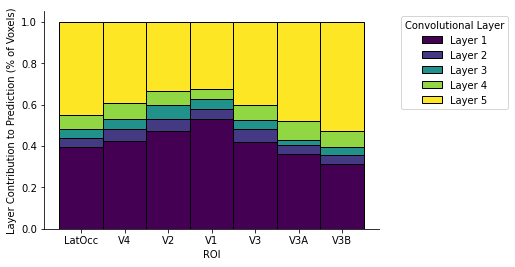

In [ ]:
# =========================================================
# Layer Contributions as Percentage of Voxels (highest R2)
# =========================================================

from matplotlib import cm
viridis = cm.get_cmap('viridis', 7)

bestr2idx = [None] * 7
r2hist = np.zeros(shape = (7,5))
# for i,r in enumerate(['V1', 'V2', 'V3',  'V4', 'LatOcc','V3A', 'V3B']):
for i,r in enumerate(['LatOcc', 'V4',  'V2','V1', 'V3','V3A', 'V3B']):
  r2scores = np.load('r2scores_%s_layer0.npy' % r)
  nvx = r2scores.shape[2]
  bestr2 = np.zeros((5,nvx))
  for l in range(5):
    r2scores = np.load('r2scores_%s_layer%d.npy' % (r,l))
    allseeds,res = create_2d_gaussian_grid(l,outputs)
    nvx = r2scores.shape[2]
    bestidx = np.argmax(r2scores.reshape((len(alphas) * allseeds.shape[0],nvx)),axis = 0)
    bestr2[l,:] = np.amax(np.squeeze(r2scores),axis = 0)
  bestr2idx[i] = np.argmax(bestr2,axis = 0)
  tmp = np.histogram(np.argmax(bestr2,axis = 0),bins = (0,1,2,3,4,5))
  r2hist[i,:] = tmp[0]

# r2hist = r2hist / np.tile(np.sum(r2hist,axis = 1).reshape((3,1)),(1,5))
r2hist = r2hist / np.tile(np.sum(r2hist,axis = 1).reshape((7,1)),(1,5))

print(r2hist)
# for i in reversed(range(1,5,1)):
#   plt.bar(['V1,','V2','V3','V3A','V3B','V4','LOC'],r2hist[:,i])
# plt.bar(['V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LatOcc'],r2hist[:,4])

# The position of the bars on the x-axis
r = [0,1,2,3,4,5,6]

# Names of group and bar width
# names = ['V1', 'V2', 'V3',  'V4', 'LatOcc','V3A', 'V3B']
names = ['LatOcc', 'V4',  'V2','V1', 'V3','V3A', 'V3B']
barWidth = 1

r2hist.shape

plt.bar(r, r2hist[:,0], color=viridis(0), edgecolor='black', width=barWidth,label = 'Layer 1')
plt.bar(r, r2hist[:,1], bottom=r2hist[:,0], color=viridis(0.25), edgecolor='black', width=barWidth,label = 'Layer 2')
plt.bar(r, r2hist[:,2], bottom=r2hist[:,1] + r2hist[:,0], color=viridis(0.5), edgecolor='black', width=barWidth,label = 'Layer 3')
plt.bar(r, r2hist[:,3], bottom=r2hist[:,2] + r2hist[:,1] + r2hist[:,0], color=viridis(0.75), edgecolor='black', width=barWidth, label = 'Layer 4')
plt.bar(r, r2hist[:,4], bottom=r2hist[:,3] + r2hist[:,2] + r2hist[:,1] + r2hist[:,0], color=viridis(.99), edgecolor='black', width=barWidth, label = 'Layer 5')
plt.xticks(r, names)
plt.xlabel("ROI")
plt.ylabel("Layer Contribution to Prediction (% of Voxels)")
plt.legend( title='Convolutional Layer', bbox_to_anchor=(1.05, 1), loc='upper left')#, fontsize='xx-small')
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.savefig('LayerContributionPct.eps',format = 'eps',bbox_inches = 'tight')



In [ ]:
# Predict test set voxel activity
def fwRF_test(region,train_activation, test_activation,dat):
  roiname = dat['roi_names'][region]
  y_train = np.squeeze(dat['responses'][:,np.where(dat['roi'] == region)])
  y_test = np.squeeze(dat['responses_test'][:,np.where(dat['roi'] == region)])

  # loop over layers
  for l in range(5):
    r2scores = np.load('r2scores_%s_layer%d.npy' % (roiname,l)) # load training r2
    allseeds,res = create_2d_gaussian_grid(l,train_activation)
    nvx = r2scores.shape[2]
    bestidx = np.argmax(r2scores.reshape((len(alphas) * allseeds.shape[0],nvx)),axis = 0)
    bestr2 = np.amax(np.squeeze(r2scores),axis = 0)
    
    X_train = train_activation[l].detach().numpy()
    ntrain = X_train.shape[0]
    ntrainchan = X_train.shape[1]  
    X_train_FWRF = np.zeros((ntrain,ntrainchan))

    X_test = test_activation[l].detach().numpy()
    ntest = X_test.shape[0]
    ntestchan = X_test.shape[1]
    X_test_FWRF =  np.zeros((ntest,ntestchan))

    y_test_pred = np.zeros((ntest,nvx))
    r2 = np.zeros((nvx,1))

    # loop over voxels
    for v in range(nvx):
      # generate 2D gaussian
      vxgauss_train = np.tile(makegaussian2d(np.max(res),
                                       allseeds[bestidx[v],0],
                                       allseeds[bestidx[v],1],
                                       allseeds[bestidx[v],2],
                                       allseeds[bestidx[v],2]),
                        (ntrain,1,1))

      vxgauss_test = np.tile(makegaussian2d(np.max(res),
                                  allseeds[bestidx[v],0],
                                  allseeds[bestidx[v],1],
                                  allseeds[bestidx[v],2],
                                  allseeds[bestidx[v],2]),
                  (ntest,1,1))
      
      # convolve each channel w/ 2D gaussian
      #for k in range(0,nchan):
      for k in range(0,ntrainchan):
        X_train_FWRF[:,k] = np.sum(vxgauss_train*X_train[:,k,:,:],axis = (1,2))
        X_test_FWRF[:,k] = np.sum(vxgauss_test*X_test[:,k,:,:],axis = (1,2))
      
      ridge_reg_model  = linear_model.Ridge(alpha = 0.5)
      ridge_reg_model.fit(X_train_FWRF, y_train[:,v])
      y_test_pred[:,v] = ridge_reg_model.predict(X_test_FWRF)
      r2[v] = r2_score(y_test[:,v], y_test_pred[:,v])
    
    # save
    np.save('testpred_%s_layer%d.npy' % (roiname,l) ,y_test_pred)
    np.save('testr2_%s_layer%d.npy' % (roiname,l),r2)
    

In [ ]:
train_activation = np.load('layer_activation.npy',allow_pickle=True)
test_activation = np.load('testlayer_activation.npy',allow_pickle=True)
fwRF_test(7,train_activation, test_activation,dat) # run this for all regions (1:7)

[0.64450511]
[[1.         0.83519443]
 [0.83519443 1.        ]]


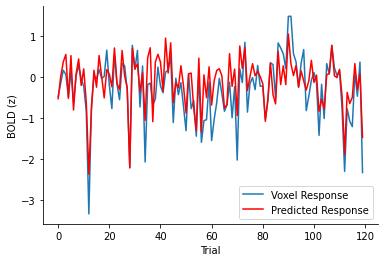

In [ ]:
r2 = np.load('testr2_V1_layer0.npy')
y_test_pred = np.load('testpred_V1_layer0.npy')



vxidx = 1137
print(r2[vxidx])
y_test = np.squeeze(dat['responses_test'][:,np.where(dat['roi'] == 1)])
plt.plot(y_test[:,vxidx],label = 'Voxel Response')
plt.plot(y_test_pred[:,vxidx],'r',label = 'Predicted Response')
plt.xlabel('Trial')
plt.ylabel('BOLD (z)')
plt.legend()
print(np.corrcoef(y_test_pred[:,vxidx],y_test[:,vxidx]))
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.savefig('pred_actual_response_test_example_V1_vx17.eps',format = 'eps')

In [ ]:
r2scores = np.load('testr2_%s_layer0.npy' % r)
r2scores.shape

(928, 1)

[[0.27155172 0.1875     0.14439655 0.1637931  0.23275862]
 [0.27752443 0.1713355  0.12833876 0.16026059 0.26254072]
 [0.34901584 0.17474796 0.12914066 0.14402304 0.20307249]
 [0.38176198 0.16924266 0.11051005 0.10432767 0.23415765]
 [0.27318436 0.17877095 0.15195531 0.1547486  0.24134078]
 [0.23140496 0.16942149 0.12190083 0.15495868 0.32231405]
 [0.2133758  0.1910828  0.14649682 0.14968153 0.29936306]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


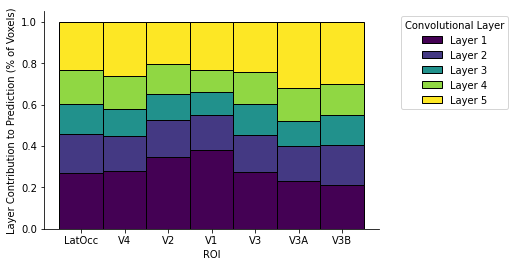

In [ ]:
# =========================================================
# Layer Contributions as Percentage of Voxels (highest R2)
# =========================================================

from matplotlib import cm
viridis = cm.get_cmap('viridis', 7)

bestr2idx = [None] * 7
r2hist = np.zeros(shape = (7,5))
# for i,r in enumerate(['V1', 'V2', 'V3',  'V4', 'LatOcc','V3A', 'V3B']):
for i,r in enumerate(['LatOcc', 'V4',  'V2','V1', 'V3','V3A', 'V3B']):
  r2scores = np.load('testr2_%s_layer0.npy' % r)
  nvx = r2scores.shape[0]
  bestr2 = np.zeros((5,nvx))
  for l in range(5):
    r2scores = np.load('testr2_%s_layer%d.npy' % (r,l))
    # allseeds,res = create_2d_gaussian_grid(l,test_activation)
    # bestidx = np.argmax(r2scores.reshape((len(alphas) * allseeds.shape[0],nvx)),axis = 0)
    bestr2[l,:] = r2scores.reshape((1,nvx))  #np.amax(np.squeeze(r2scores),axis = 0)
  bestr2idx[i] = np.argmax(bestr2,axis = 0)
  tmp = np.histogram(np.argmax(bestr2,axis = 0),bins = (0,1,2,3,4,5))
  r2hist[i,:] = tmp[0]

# r2hist = r2hist / np.tile(np.sum(r2hist,axis = 1).reshape((3,1)),(1,5))
r2hist = r2hist / np.tile(np.sum(r2hist,axis = 1).reshape((7,1)),(1,5))

print(r2hist)
# for i in reversed(range(1,5,1)):
#   plt.bar(['V1,','V2','V3','V3A','V3B','V4','LOC'],r2hist[:,i])
# plt.bar(['V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LatOcc'],r2hist[:,4])

# The position of the bars on the x-axis
r = [0,1,2,3,4,5,6]

# Names of group and bar width
# names = ['V1', 'V2', 'V3',  'V4', 'LatOcc','V3A', 'V3B']
names = ['LatOcc', 'V4',  'V2','V1', 'V3','V3A', 'V3B']
barWidth = 1

r2hist.shape

plt.bar(r, r2hist[:,0], color=viridis(0), edgecolor='black', width=barWidth,label = 'Layer 1')
plt.bar(r, r2hist[:,1], bottom=r2hist[:,0], color=viridis(0.25), edgecolor='black', width=barWidth,label = 'Layer 2')
plt.bar(r, r2hist[:,2], bottom=r2hist[:,1] + r2hist[:,0], color=viridis(0.5), edgecolor='black', width=barWidth,label = 'Layer 3')
plt.bar(r, r2hist[:,3], bottom=r2hist[:,2] + r2hist[:,1] + r2hist[:,0], color=viridis(0.75), edgecolor='black', width=barWidth, label = 'Layer 4')
plt.bar(r, r2hist[:,4], bottom=r2hist[:,3] + r2hist[:,2] + r2hist[:,1] + r2hist[:,0], color=viridis(.99), edgecolor='black', width=barWidth, label = 'Layer 5')
plt.xticks(r, names)
plt.xlabel("ROI")
plt.ylabel("Layer Contribution to Prediction (% of Voxels)")
plt.legend( title='Convolutional Layer', bbox_to_anchor=(1.05, 1), loc='upper left')#, fontsize='xx-small')
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.savefig('LayerContributionPct_test.eps',format = 'eps',bbox_inches = 'tight')



#Decoding

In [ ]:
# load training and test CNN activations
train_activation = np.load('layer_activation.npy',allow_pickle=True)
test_activation = np.load('testlayer_activation.npy',allow_pickle=True)

440


0.7

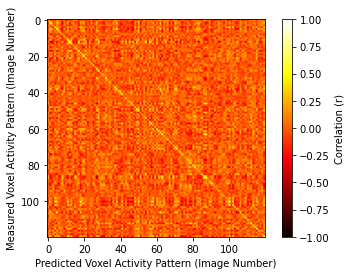

In [ ]:
# decoding for individual ROI and layer
roi_name = 'V1'
roi_num = 1
layer_num = 0
r2scores = np.load('r2scores_%s_layer%d.npy' % (roi_name,layer_num))
allseeds,res = create_2d_gaussian_grid(layer_num,outputs)
nvx = r2scores.shape[2]
bestidx = np.argmax(r2scores.reshape((len(alphas) * allseeds.shape[0],nvx)),axis = 0)
bestr2 = np.amax(np.squeeze(r2scores),axis = 0)
y_test = np.squeeze(dat['responses_test'][:,np.where(dat['roi'] == roi_num)])
y_test_pred = np.load('testpred_%s_layer%d.npy' % (roi_name,layer_num))
r2 = np.load('testr2_%s_layer%d.npy' % (roi_name,layer_num))


vxidx = np.where(bestr2 > 0.01)[0]
print(len(vxidx))
cormat = np.zeros(shape = (120,120))
for i in range(120):
  for j in range(120):
    cormat[i,j] = np.corrcoef(y_test[i,vxidx],y_test_pred[j,vxidx])[0][1]

#plt.figure(figsize = (4,4))
plt.imshow(cormat,cmap = 'hot',vmin=-1, vmax=1)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Correlation (r)')#, rotation=270)
plt.ylabel('Measured Voxel Activity Pattern (Image Number)')
plt.xlabel('Predicted Voxel Activity Pattern (Image Number)')
cormat.shape
np.sum(np.abs(np.argmax(cormat,axis = 1) - np.arange(0,120,1)) == 0)/120
plt.savefig('V1_layer0_identification.eps',format = 'eps')
#np.sum((np.argmax(cormat,axis = 0) - np.arange(0,120,1)) == 0)/120
np.sum(np.abs(np.argmax(cormat,axis = 1) - np.arange(0,120,1)) == 0)/120

#np.abs(np.argmax(cormat,axis = 1) - np.arange(0,120,1))

0.3400309119010819

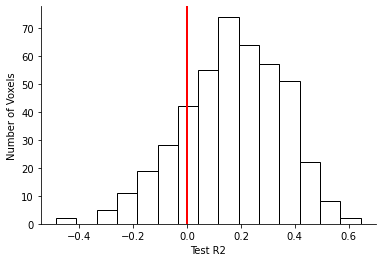

In [ ]:
# prediction performance histogram
plt.hist(r2[bestr2 > 0.01],color = 'white',edgecolor = 'black',bins=15)
plt.axvline(x=0,color = 'red',linewidth = 2)
plt.xlabel('Test R2')
plt.ylabel('Number of Voxels')
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
np.sum(r2[bestr2 > 0.01] > 0)/len(r2[bestr2 > 0.01])
len(r2[bestr2 > 0.01])
plt.savefig('testr2_histogram.eps',format = 'eps')
440/1294

36
[ 14  22  31  33  35  36  38  42  44  45  51  53  55  64  65  67  69  72
  75  76  84  85  88  91  92  93  95  98  99 101 105 106 108 111 116 117]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.
   0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  7.  0.  1.  0. 19.
  17.  0.  4.  0.  0.  0.  4.  0.  5.  2.  0.  0.  0.  0.  0.  7.  0.  2.
   0. 14.  0.  0.  0.  0.  0.  0.  0.  0.  4.  1.  0.  1.  0.  1.  0.  0.
   1.  0.  0. 10.  4.  0.  0.  0.  0.  0.  0.  0. 33.  1.  0.  0. 10.  0.
   0.  8. 12. 12.  0. 27.  0.  0. 25.  2.  0. 81.  0.  0.  0. 14.  2.  0.
   2.  0.  0. 31.  0.  0.  0.  0.  1. 13.  0.  0.]]


0.8833333333333333

<Figure size 2880x576 with 0 Axes>

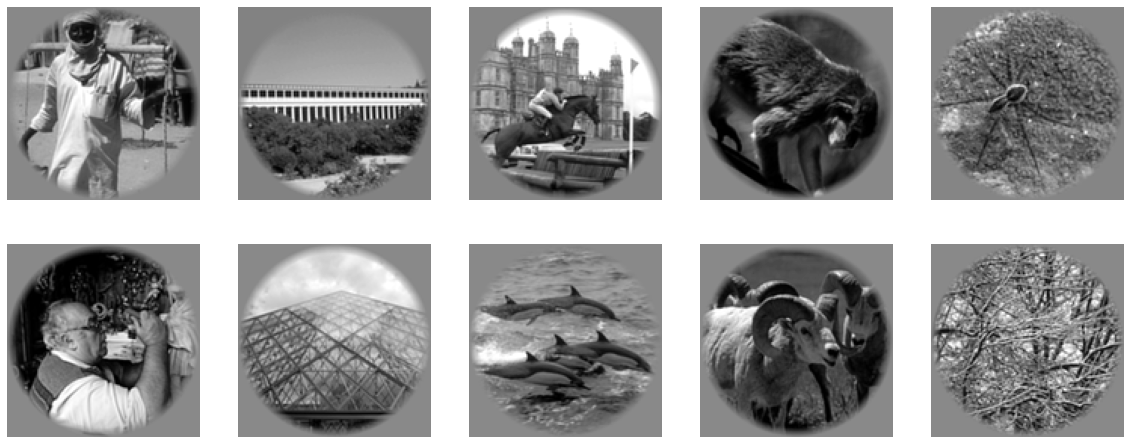

In [ ]:
mismatchidx = np.where((np.argmax(cormat,axis = 1) - np.arange(0,120,1)) != 0)[0]
predimage = np.argmax(cormat,axis = 1)
n = len(mismatchidx)
print(n)
plt.figure(figsize = (40,8))
num_images = 10

print(mismatchidx)

# for i,m in enumerate(mismatchidx[0:num_images]):
#   plt.subplot(2,num_images,i+1)
#   plt.imshow(dat['stimuli_test'][predimage[m]],cmap = 'gray')
#   plt.title('Predicted Image')
#   plt.subplot(2,num_images,i+num_images+1 )
#   plt.imshow(dat['stimuli_test'][m],cmap = 'gray')
#   plt.title('Actual Image')

# plt.figure(figsize = (40,8))
# num_images = 10
# for i,m in enumerate(mismatchidx[10:20]):
#   plt.subplot(2,num_images,i+1)
#   plt.imshow(dat['stimuli_test'][predimage[m]],cmap = 'gray')
#   plt.title('Predicted Image')
#   plt.subplot(2,num_images,i+num_images+1 )
#   plt.imshow(dat['stimuli_test'][m],cmap = 'gray')
#   plt.title('Actual Image')

# plt.figure(figsize = (40,8))
# num_images = 10
# for i,m in enumerate(mismatchidx[20:30]):
#   plt.subplot(2,num_images,i+1)
#   plt.imshow(dat['stimuli_test'][predimage[m]],cmap = 'gray')
#   plt.title('Predicted Image')
#   plt.subplot(2,num_images,i+num_images+1 )
#   plt.imshow(dat['stimuli_test'][m],cmap = 'gray')
#   plt.title('Actual Image')

# plt.figure(figsize = (40,8))
# num_images = 10
# for i,m in enumerate(mismatchidx[30:36]):
#   plt.subplot(2,num_images,i+1)
#   plt.imshow(dat['stimuli_test'][predimage[m]],cmap = 'gray')
#   plt.title('Predicted Image')
#   plt.subplot(2,num_images,i+num_images+1 )
#   plt.imshow(dat['stimuli_test'][m],cmap = 'gray')
#   plt.title('Actual Image')


#mismatchidx = mismatchidx[np.array([0,1, 4, 11,13])]
#predimage = predimage[np.array([0,1, 4, 11,13])]

plt.figure(figsize = (20,8))
# print(mismatchidx[1])
# print(predimage[3])
num_images = 5
# # for i,m in enumerate(mismatchidx[0:num_images]):
for i,m in enumerate(np.array([3,16,18, 19, 23])):   # enumerate(np.array([0,1, 4, 22,24])):
  plt.subplot(2,num_images,i+1)
  ax = plt.imshow(dat['stimuli_test'][predimage[mismatchidx[m]]],cmap = 'gray')
  #plt.title('Predicted Image',fontsize = 18)
  plt.axis('off')
  plt.subplot(2,num_images,i+num_images+1 )
  plt.imshow(dat['stimuli_test'][mismatchidx[m]],cmap = 'gray')
  #plt.title('Actual Image',fontsize = 18)
  plt.axis('off')
plt.savefig('V1_layer0_Predicted_vs_Actual_Image_Alt.eps',format = 'eps')




corranks = np.argsort(-cormat, axis = 1)
ranks = np.zeros(shape = (1,cormat.shape[1]))
ranks.shape
for i in range(cormat.shape[0]):
  ranks[0,i] = np.where(corranks[i,:] == i)[0]

print(ranks)
np.sum(ranks < 10)/120

In [ ]:
np.arange(cormat.shape[1])[::-1]

array([119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107,
       106, 105, 104, 103, 102, 101, 100,  99,  98,  97,  96,  95,  94,
        93,  92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,  81,
        80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,  68,
        67,  66,  65,  64,  63,  62,  61,  60,  59,  58,  57,  56,  55,
        54,  53,  52,  51,  50,  49,  48,  47,  46,  45,  44,  43,  42,
        41,  40,  39,  38,  37,  36,  35,  34,  33,  32,  31,  30,  29,
        28,  27,  26,  25,  24,  23,  22,  21,  20,  19,  18,  17,  16,
        15,  14,  13,  12,  11,  10,   9,   8,   7,   6,   5,   4,   3,
         2,   1,   0])

In [ ]:
dat['roi_names'][1:]

array(['V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LatOcc'], dtype='<U6')

In [ ]:
# Extract best R2 for each voxel
nvx = 8428
roi_names  = dat['roi_names'][1:]
bestr2 = np.zeros(shape = (nvx,))
bestidx = np.zeros(shape = (nvx,))
y_test_pred = [np.zeros(shape = (120,nvx))] * 5
for i, r in enumerate(roi_names):
  # load training r2 and test predictions for each layer
  r2_train_fn = sorted(glob.glob('r2scores_%s_layer*' % r))
  pred_test_fn = sorted(glob.glob('testpred_%s_layer*' % r))

  for l in range(5):
    # load training r2 and determine best index
    r2scores = np.load(r2_train_fn[l]) # load training r2
    #allseeds,res = create_2d_gaussian_grid(l,train_activation)
    nroivx = r2scores.shape[2]
    if l == 0:
      tmpbestr2 = np.zeros(shape = (5,nroivx))
    # #bestidx = np.argmax(r2scores.reshape((len(alphas) * allseeds.shape[0],nvx)),axis = 0)
    tmpbestr2[l,:] = np.amax(np.squeeze(r2scores),axis = 0)

    # load test predictions
    tmp = np.load(pred_test_fn[l])   
    y_test_pred[l][:,dat['roi'] == (i + 1)] = tmp


  tmpbestidx = np.argmax(tmpbestr2,axis = 0)
  tmpbestr2 = np.amax(np.squeeze(r2scores),axis = 0)

  bestidx[dat['roi'] == (i + 1)] = tmpbestidx
  bestr2[dat['roi'] == (i + 1)] = tmpbestr2
nvx = bestr2.shape[0]

In [ ]:
bestidx.shape

(8428,)

328


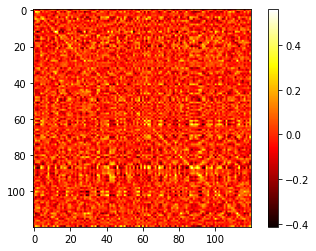

0.2833333333333333

In [ ]:
# compute test image correlation matrix
cormat = np.zeros(shape = (120,120))
y_pred = np.zeros(shape = (120,nvx))
for v in range(nvx):
  y_pred[:,v] = y_test_pred[int(bestidx[v])][:,v].reshape((120,))
  # y_pred[:,v] = y_test_pred[0][:,v].reshape((120,))


print(np.sum((bestr2 > 0.01) & (dat['roi'] == 1)  & (bestidx == 0)))


#y_pred = y_pred[:,(bestr2 > 0.01) & (dat['roi'] == 1)  & (bestidx == 0)]
y_pred = y_pred[:,(bestr2 > 0.01)]

# y_test = np.squeeze(dat['responses_test'][:,np.where(dat['roi'] == 1)])

y_test = dat['responses_test']
y_test = y_test[:,(bestr2 > 0.01)]
#y_test = y_test[:,(bestr2 > 0.01) & (dat['roi'] == 1)  & (bestidx == 0)]

for i in range(120):
  for j in range(120):
    cormat[i,j] = np.corrcoef(y_test[i,:],y_pred[j,:])[0][1]

plt.imshow(cormat,cmap = 'hot')
plt.colorbar()
plt.show()

np.sum((np.argmax(cormat,axis = 1) - np.arange(0,120,1)) == 0)/120


#plt.plot(y_pred[0,:])

In [ ]:
vxidx = np.where(bestr2 > 0.01)[0]
cormat = np.zeros(shape = (120,120))
for i in range(120):
  for j in range(120):
    cormat[i,j] = np.corrcoef(y_test[i,vxidx],y_pred[j,vxidx])[0][1]
    # cormat[i,j],_ = sp.stats.spearmanr(y_test[i,:], y_test_pred[j,:])

plt.imshow(cormat)
plt.colorbar()
cormat.shape
np.sum(np.abs(np.argmax(cormat,axis = 1) - np.arange(0,120,1)) == 0)/120


IndexError: ignored

In [ ]:
y_pred = y_pred[:,bestr2 > 0.01]
y_pred.shape

(120, 1877)

86


array([ 75,  19,  41,  62,  32,  47,  69,  62,  47,  58,  91,  63,  21,
        88,  93,  23,  17,   4,  47,   7, 112,  51, 103,  78,  30, 119,
        12,  48,  11,  15,  24,  80,  36,   1,  91,  81,  87,  58,  58,
        69,  94, 112,  35,  11,  35,  34,   9,  50,   8,  35, 119,  86,
         1,  78,   0,  51,  93,  91,  42,  96,  93,  46,  69,   8,  41,
        51,  44,  42,  85, 101,  58, 114,  96,  74,  58,  78, 107,  79,
        72,  63,  10, 100,   2,  41,   8,  48])

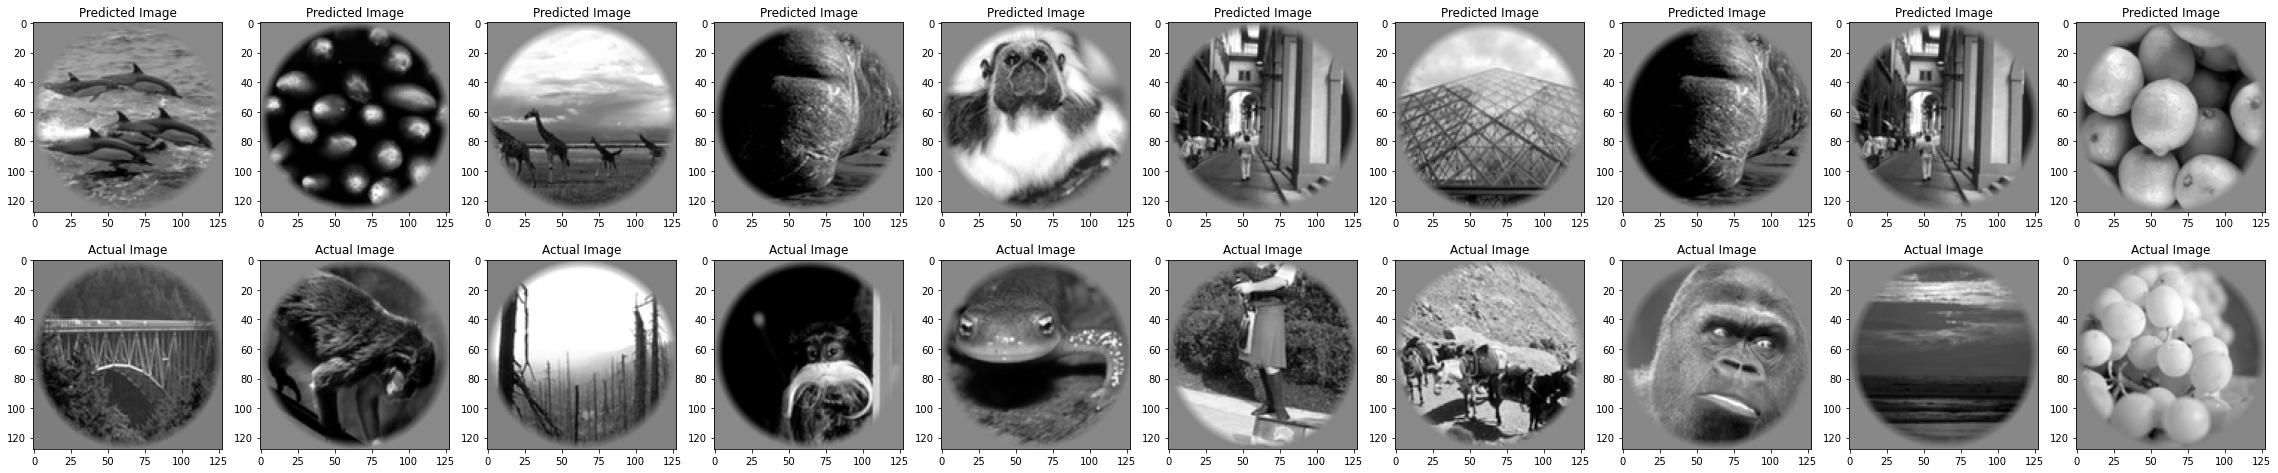

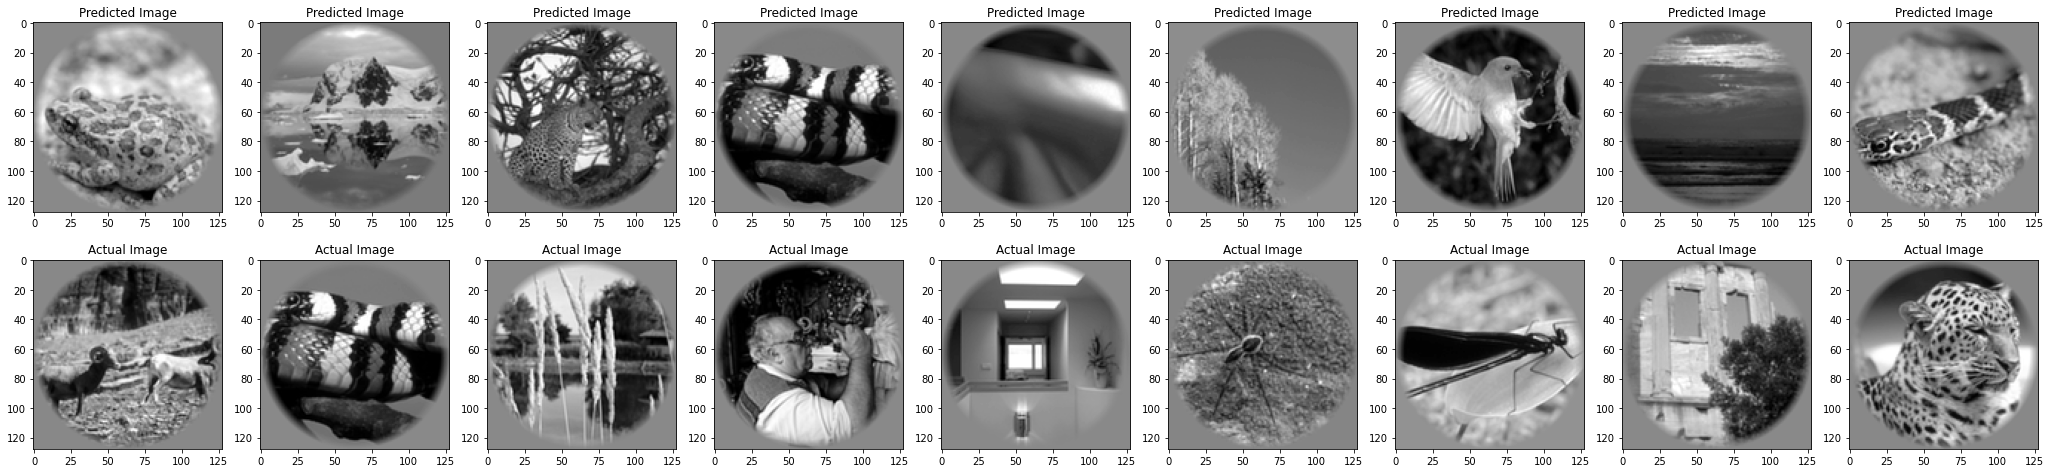

In [ ]:
mismatchidx = np.where((np.argmax(cormat,axis = 1) - np.arange(0,120,1)) != 0)[0]
predimage = np.argmax(cormat,axis = 1)
n = len(mismatchidx)
print(n)
plt.figure(figsize = (40,8))
num_images = 10
for i,m in enumerate(mismatchidx[0:num_images]):
  plt.subplot(2,num_images,i+1)
  plt.imshow(dat['stimuli_test'][predimage[m]],cmap = 'gray')
  plt.title('Predicted Image')
  plt.subplot(2,num_images,i+num_images+1 )
  plt.imshow(dat['stimuli_test'][m],cmap = 'gray')
  plt.title('Actual Image')

plt.figure(figsize = (40,8))
num_images = 10
for i,m in enumerate(mismatchidx[21:30]):
  plt.subplot(2,num_images,i+1)
  plt.imshow(dat['stimuli_test'][predimage[m]],cmap = 'gray')
  plt.title('Predicted Image')
  plt.subplot(2,num_images,i+num_images+1 )
  plt.imshow(dat['stimuli_test'][m],cmap = 'gray')
  plt.title('Actual Image')

predimage[mismatchidx]

In [ ]:
np.argmax(cormat,axis = 0)

array([ 87,   1,   2, 118,   4,   5,   6,   7,  87,   9,  10,  11,  12,
        13,  81,  87,  16,  17, 100,  19,  20,  21,  73,  23,  24,  25,
        26,  50,  28,  91, 112,  91,  32,  33,  34,  91, 100,  37,   5,
        39,  40,  41,  91,  12,  91,  12,  46,  12, 100,  49,  50,  87,
        48,  53,  12, 106,  12,  57, 100,  87,  60,  61, 106,  63, 100,
        12,  66,  91, 112,  87, 119,  71, 115,  91,  74,  95,  91,  77,
        81, 112,  80,  81, 119,   2, 119,  85,  86,  87,  91, 100,  90,
        91,  77, 112,  94,  18,  96, 112, 100,  90, 100,  33, 102, 103,
       104,  85, 106, 107,  77,  80, 110,  12, 112, 102, 114, 115,   5,
        37, 118, 119])

#RSA

In [ ]:
def show_stimulus(img, ax=None):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img, cmap=mpl.cm.binary)
  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

def plot_corr_matrix(rdm,vmin = 0.0,vmax = 2.0, ax=None):
  """Plot dissimilarity matrix

  Args:
    rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
      matrix
    ax (matplotlib axes): axes onto which to plot

  Returns:
    nothing

  """
  if ax is None:
    ax = plt.gca()
  image = ax.imshow(rdm, vmin=vmin, vmax=vmax,cmap = 'hot')
  ax.set_xticks([])
  ax.set_yticks([])
  cbar = plt.colorbar(image, ax=ax, label='dissimilarity')

def plot_multiple_rdm(rdm_dict,vmin = np.array([0.0]),vmax = np.array([2.0])):
  """Draw multiple subplots for each RDM in rdm_dict."""
  fig, axs = plt.subplots(1, len(rdm_dict),
                          figsize=(4 * len(rdm_dict), 3.5))

  # Compute RDM's for each set of responses and plot
  for i, (label, rdm) in enumerate(rdm_dict.items()):

    image = plot_corr_matrix(rdm,vmin[i],vmax[i],axs[i])
    axs[i].set_title(label)

# def plot_multiple_rdm(rdm_dict,vmin = 0.0,vmax = 2.0):
#   """Draw multiple subplots for each RDM in rdm_dict."""
#   fig, axs = plt.subplots(1, len(rdm_dict),
#                           figsize=(4 * len(rdm_dict), 3.5))

#   # Compute RDM's for each set of responses and plot
#   for i, (label, rdm) in enumerate(rdm_dict.items()):

#     image = plot_corr_matrix(rdm,vmin,vmax,axs[i])
#     axs[i].set_title(label)


def plot_rdm_rdm_correlations(rdm_sim,roi_label):
  """Draw a bar plot showing between-RDM correlations."""
  f, ax = plt.subplots()
  ax.bar(rdm_sim.keys(), rdm_sim.values())
  ax.set_xlabel('Deep network model layer')
  ax.set_ylabel('Correlation of model layer RDM\nwith %s RDM' % roi_label)


def plot_rdm_rows(ori_list, rdm_dict, rdm_oris):
  """Plot the dissimilarity of response to each stimulus with response to one
  specific stimulus

  Args:
    ori_list (list of float): plot dissimilarity with response to stimulus with
      orientations closest to each value in this list
    rdm_dict (dict): RDM's from which to extract dissimilarities
    rdm_oris (np.ndarray): orientations corresponding to each row/column of RDMs
    in rdm_dict

  """
  n_col = len(ori_list)
  f, axs = plt.subplots(1, n_col, figsize=(4 * n_col, 4), sharey=True)

  # Get index of orientation closest to ori_plot
  for ax, ori_plot in zip(axs, ori_list):
    iori = np.argmin(np.abs(rdm_oris - ori_plot))

    # Plot dissimilarity curves in each RDM
    for label, rdm in rdm_dict.items():
      ax.plot(rdm_oris, rdm[iori, :], label=label)

    # Draw vertical line at stimulus we are plotting dissimilarity w.r.t.
    ax.axvline(rdm_oris[iori], color=".7", zorder=-1)

    # Label axes
    ax.set_title(f'Dissimilarity with response\nto {ori_plot: .0f}$^o$ stimulus')
    ax.set_xlabel('Stimulus orientation ($^o$)')

  axs[0].set_ylabel('Dissimilarity')
  axs[-1].legend(loc="upper left", bbox_to_anchor=(1, 1))

In [ ]:
def RDM(resp):
  """Compute the representational dissimilarity matrix (RDM)

  Args:
    resp (ndarray): S x N matrix with population responses to
      each stimulus in each row

  Returns:
    ndarray: S x S representational dissimilarity matrix
  """
  #########################################################
  ## TO DO for students: compute representational dissimilarity matrix
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: complete function RDM")
  #########################################################

  # z-score responses to each stimulus
  zresp = zscore(resp, axis=1)

  # Compute RDM
  RDM = 1 - (zresp @ zresp.T) / zresp.shape[1]

  return RDM

def correlate_rdms(rdm1, rdm2):
  """Correlate off-diagonal elements of two RDM's
  Args:
    rdm1 (np.ndarray): S x S representational dissimilarity matrix
    rdm2 (np.ndarray): S x S representational dissimilarity matrix to
      correlate with rdm1
  Returns:
    float: correlation coefficient between the off-diagonal elements
      of rdm1 and rdm2
  """

  # Extract off-diagonal elements of each RDM
  ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
  rdm1_offdiag = rdm1[ioffdiag]
  rdm2_offdiag = rdm2[ioffdiag]

  corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]

  return corr_coef

In [ ]:
from scipy.stats import zscore
vmin = np.zeros((6,1))
vmax = np.zeros((6,1))
y_response = np.squeeze(fmri_data[:,np.where(dat['roi'] == 2)]) # extract ROI
# y_response = y_response[:,bestr2 > 0.01]
print(y_response.shape)
roin = 'v1'
rdm_dict = dict()
rdm_dict[roin] = RDM(y_response)
vmin[0] = np.percentile(rdm_dict[roin],2.5)
vmax[0] = np.percentile(rdm_dict[roin],97.5)
for i in range(len(outputs)):
  X_features = outputs[i].detach().numpy()
  X_features = np.reshape(X_features,(num_samples,X_features.shape[1] * X_features.shape[2] * X_features.shape[3]))
  # X_features = (X_features - np.nanmean(X_features, axis = 0))/(np.nanstd(X_features,axis = 0))
  # X_features = zscore(np.reshape(X_features,(num_samples,X_features.shape[1] * X_features.shape[2] * X_features.shape[3])),axis=0)
  rdm_dict['Layer %d' % i] = RDM(X_features)
  vmin[i+1] = np.percentile(RDM(X_features),2.5)
  vmax[i+1] = np.percentile(RDM(X_features),97.5)

# correlate RDMs
# Split RDMs into V1 responses and model responses
rdm_model = rdm_dict.copy()
rdm_roi = rdm_model.pop(roin)
# Correlate off-diagonal terms of dissimilarity matrices
rdm_sim = {label: correlate_rdms(rdm_roi, rdm) for label, rdm in rdm_model.items()}

NameError: ignored

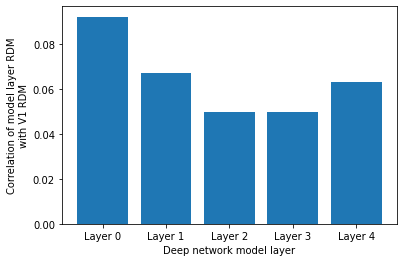

In [ ]:
# Visualize
plot_rdm_rdm_correlations(rdm_sim,roin)
plt.savefig('correlations_v2', format='eps')

In [ ]:
# Plot RDMs
plot_multiple_rdm(rdm_dict,vmin = vmin,vmax = vmax)
plt.savefig('multiple_RDM_loc.pdf', format = 'pdf')

## Retinotopic Mapping: 

### Let us see if we can answer two questions for some of the voxels in visual cortex: 1- where in the visual field this particular voxel is looking at?  2- What kind of features this voxel is extracting?

In [ ]:
def vcorrcoef(X,y):
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    ym = np.mean(y)
    r_num = np.sum((X-Xm)*(y-ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r

def imshow(img, title):
  
  """Custom function to display the image using matplotlib"""
  
  #define std correction to be made
  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  
  #define mean correction to be made
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  
  #convert the tensor img to numpy img and de normalize 
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction
  
  #plot the numpy image
  plt.figure(figsize = (batch_size * 4, 4))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

#custom function to fetch images from dataloader

def show_batch_images(dataloader):
  images,_ = next(iter(dataloader))
  
  #run the model on the images
  outputs = model(images)
  
  #get the maximum class 
  _, pred = torch.max(outputs.data, 1)
  
  #make grid
  img = torchvision.utils.make_grid(images)
  
  #call the function
  imshow(img, title=[classes[x.item()] for x in pred])
  
  return images, pred

def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg,cmap = 'gray')
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor,kernel_num)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")



In [ ]:
# alexnet = models.alexnet(pretrained=True)

# from torchvision import transforms
# transform = transforms.Compose([           #[1]
# transforms.Grayscale(3),
# transforms.Resize(256),                    #[2]
# transforms.CenterCrop(224),                #[3]
# transforms.ToTensor(),                     #[4]
# transforms.Normalize(                      #[5]
# mean=[0.485, 0.456, 0.406],                #[6]
# std=[0.229, 0.224, 0.225]                  #[7]
# )])

# unloader = transforms.ToPILImage()
# def tensor_to_PIL(tensor):
#     image = tensor.cpu().clone()
#     image = image.squeeze(0)
#     image = unloader(image)
#     return image

# num_samples = dat['stimuli'].shape[0]
# stimuli_images = torch.zeros((num_samples, 3,224, 224))

# for im in range(num_samples):
#   test_image = dat['stimuli'][im]
#   dat_tensor = torch.from_numpy(test_image)
#   stimuli_pil = tensor_to_PIL(dat_tensor)
#   stimuli_transform = transform(stimuli_pil)
#   stimuli_images[im,:,:,:] = stimuli_transform

# alexnet.eval()
# # prediction = alexnet(stimuli_images)
# # print(prediction.shape)
# # plt.plot(prediction.detach().cpu().numpy().T)
# # plt.show()

# # print(stimuli_images.shape)

# no_of_layers=0
# conv_layers=[]
# ReLU = []
# maxpool2d = []
 
# model_children=list(alexnet.children())

# for child in model_children:
#   if type(child)==nn.Conv2d:
#     no_of_layers+=1
#     conv_layers.append(child)
#   elif type(child)==nn.Sequential:
#     for layer in child.children():
#       if (type(layer)==nn.Conv2d):
#         no_of_layers+=1
#         conv_layers.append(layer)
#       elif type(layer) == nn.ReLU:
#         no_of_layers+=1
#         ReLU.append(layer)
#       elif type(layer) == nn.MaxPool2d:
#         no_of_layers+=1
#         maxpool2d.append(layer)

# # print(no_of_layers)
# activation = [conv_layers[0](stimuli_images)]



In [ ]:
activation = np.load('layer_activation.npy',allow_pickle=True)
#activation = activation[0]

In [ ]:
# compute voxel-convolutional layer correlation
vxnum = 5#1137 #357
X = activation[0].detach().numpy()
y = np.squeeze(dat['responses'][:,np.where(dat['roi'] == 1)]) # extract ROI
y = np.expand_dims(y[:,vxnum],axis = 1).T
X_reshape = np.reshape(X,(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])).T
corvec = vcorrcoef(X_reshape,y)

#np.corrcoef(y,X_reshape[0,:])
#X_reshape[0,:]

/var/folders/v3/07sv60xd2g3f3x24dfsss90w0000gr/T/ipykernel_64841/137212521.py:6: RuntimeWarning: invalid value encountered in true_divide
  r = r_num/r_den


(-0.5, 10.5, 10.5, -0.5)

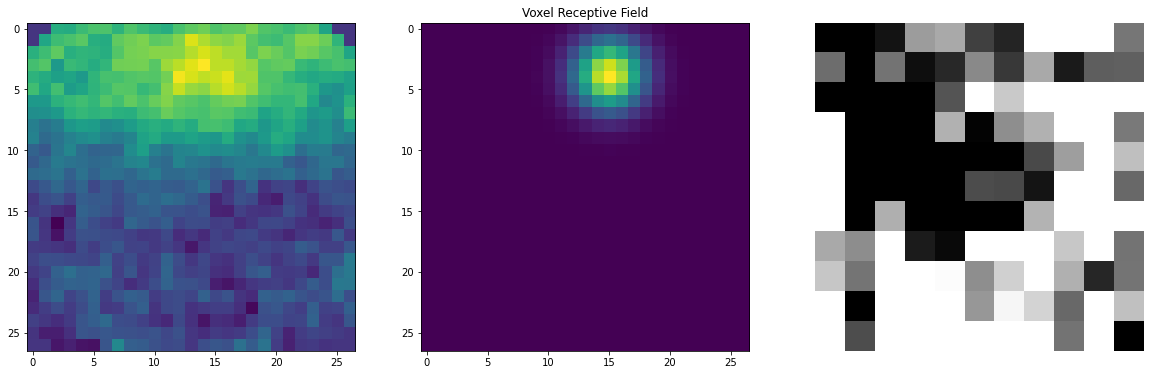

In [ ]:
plt.figure(figsize = (20,8))
# compute correlation matrix for each channel
cormat = np.reshape(corvec,(X.shape[1],X.shape[2],X.shape[3]))
bestidx = np.argmax(cormat, axis = 0) # best channel
corrmap = np.nanmax(cormat,axis = 0) # corr value for best channel

hiidx = np.where(corrmap == np.nanmax(corrmap)) 
idx = bestidx[hiidx[0],hiidx[1]]
plt.subplot(1,3,1)
plt.imshow(np.squeeze(cormat[idx,:,:]))
#plt.colorbar()

# feature pooling field
alphas = np.array([0.5])
r2scores = np.load('r2scores_V1_layer0.npy')
allseeds,res = create_2d_gaussian_grid(0,activation)
nvx = r2scores.shape[2]
bestidx = np.argmax(r2scores.reshape((len(alphas) * allseeds.shape[0],nvx)),axis = 0)
bestr2 = np.amax(np.squeeze(r2scores),axis = 0)

t =  makegaussian2d(np.max(res),allseeds[bestidx[vxnum],0],allseeds[bestidx[vxnum],1],allseeds[bestidx[vxnum],2],allseeds[bestidx[vxnum],2])
plt.subplot(1,3,2)
plt.imshow(t)
plt.title('Voxel Receptive Field')
#plt.colorbar()
plt.savefig('example_voxel_RF.eps',format = 'eps')


# plot feature weights for channel
plt.subplot(1,3,3)
alexnet = models.alexnet(pretrained=True)
alexnet.eval()
layer = alexnet.features[0]
weight_tensor = alexnet.features[0].weight.data
#get the number of kernals
# num_kernels = weight_tensor.shape[0]  
# #for each kernel, we convert the tensor to numpy 
# npimg = np.array(weight_tensor[idx].numpy(), np.float32)
# #standardize the numpy image
# npimg = (npimg - np.mean(npimg)) / np.std(npimg)
# npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
# npimg = np.squeeze(npimg)
# npimg = npimg.transpose((1, 2, 0))
# plt.imshow(npimg)
# plt.axis('off')
# # ax1.set_title(str(i))
# # plt.set_xticklabels([])
# # plt.set_yticklabels([]) 
# plt.colorbar() 


npimg = np.array(weight_tensor[idx, 1].numpy(), np.float32)
npimg = (npimg - np.mean(npimg)) / np.std(npimg)
npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
npimg = np.squeeze(npimg)
plt.imshow(npimg,cmap = 'gray')

plt.axis('off')
#plt.colorbar()


#plt.savefig('Retinotopy_vs_fwRF.eps',format = 'eps')

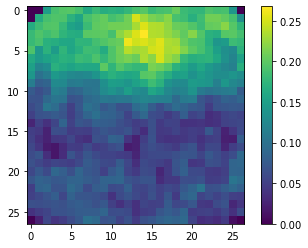

In [ ]:
plt.imshow(corrmap)
#plt.imshow(bestidx)
plt.colorbar()

## Building the Decoding Models